##### Importacion de librerias

In [458]:
import time
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import kstest, shapiro, norm
import pandas as pd
import math
import json
import sklearn
from shapely.geometry import MultiPolygon, Polygon
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (5,5)

# Ejercicio 1

#### Periodo

In [286]:
print(2**64)

18446744073709551616


#### Generador XORShift

In [287]:
class XORShiftGenerator:

  PERIOD = (2**64) 
 
  def __init__(self,external_seed):
    self.seed = external_seed % self.PERIOD
    
  #funcion para generar un numero pseudo-aleatorio
  def random(self):
    seed_tuple = (23,13,58)
    self.seed = (self.seed ^ (self.seed << seed_tuple[0])) % self.PERIOD
    self.seed = (self.seed ^ (self.seed >> seed_tuple[1])) % self.PERIOD
    self.seed = (self.seed ^ (self.seed << seed_tuple[2])) % self.PERIOD
    return self.seed
 
  #funcion para generar un numero pseudo-aleatorio entre 0 y 1
  def uniform_random(self):
    return self.random() / self.PERIOD

In [288]:
generator = XORShiftGenerator(int(time.time()))

#### Generamos 1000 numeros usando el generador

In [289]:
generated = []
uniform_generated = []

for i in range(1000):
    generated.append(generator.random())

for i in range(1000):
    uniform_generated.append(generator.uniform_random())

In [290]:
generated[0:5]

[13969599689047296,
 8594332746218579445,
 2003825501336170264,
 8165852264030238479,
 1016392969269257652]

#### Y estudiamos los resultados mediante graficos

Con este grafico facilmente se aprecia como es la distribucion de los valores generados. Vemos que no se presenta una acumulacion en un sector especifico, sino que estan bastante repartidos.

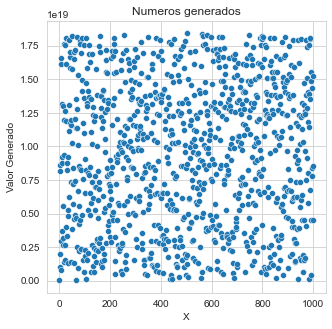

In [291]:
sns.scatterplot(data=generated)
plt.title("Numeros generados")
plt.xlabel("X")
plt.ylabel("Valor Generado")
plt.show()

Si contabilizamos entonces cuantos puntos caen en cada intervalo, vemos que no se presentan grandes diferencias en cada uno de ellos.

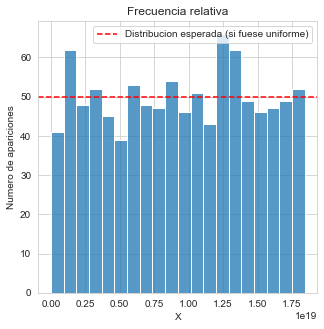

In [292]:
sns.histplot(data=generated,bins=20)
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada (si fuese uniforme)",
)
plt.title('Frecuencia relativa')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")

plt.legend()
plt.show()

#### Ahora ilustremos los valores generados entre 0 y 1

Misma distribucion de puntos, pero ahora vemos que solo se toman valores entre 0 y 1.

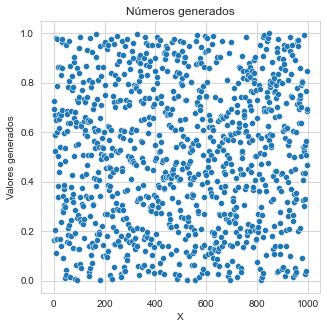

In [293]:
sns.scatterplot(data=uniform_generated)
plt.title('Números generados')
plt.ylabel("Valores generados")
plt.xlabel("X")
plt.show()

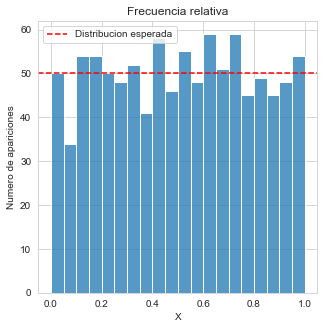

In [294]:
sns.histplot(data=uniform_generated,bins=20)
plt.title('Frecuencia relativa')
plt.ylabel("Numero de apariciones")
plt.xlabel("X")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

# Ejercicio 6.1

#### Generador GCL (Concruencial Lineal)

In [295]:
class GCL:
    # datos provistos
    
    # modulo
    m = 2**32
    
    # multiplicador
    a = 1013904223

    # incremento
    c = 1664525
    
    def __init__(self,seed):
        self.xn = seed
        
    def random(self):
        self.xn = (self.xn*self.a + self.c) % self.m
        return self.xn

    def uniform_random(self):
        return self.random() / self.m

In [296]:
# parte entera del promedio de los padrones
seed = int((99289 + 96453 + 100853 + 97839 )/4)
gcl_generator = GCL(seed) 

#### Generamos 1000 numeros usando el generador

In [297]:
gcl_generated = []
gcl_uniform_generated = []
for i in range(1000):
    gcl_generated.append(gcl_generator.random())
    gcl_uniform_generated.append(gcl_generator.uniform_random())

#### Y estudiamos los resultados mediante graficos

Vemos rapidamente con el scatterplot que la densidad de puntos se expresa de la misma manera en ambos generadores.

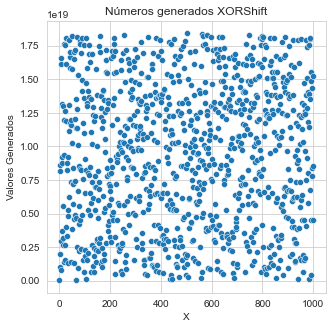

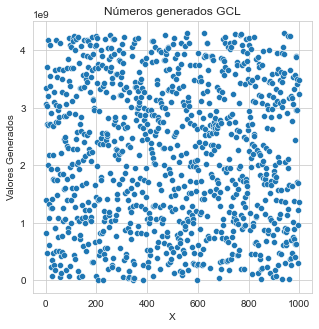

In [298]:
sns.scatterplot(data=generated)
plt.title('Números generados XORShift')
plt.xlabel("X")
plt.ylabel("Valores Generados")
plt.show()

sns.scatterplot(data=gcl_generated)
plt.title('Números generados GCL')
plt.xlabel("X")
plt.ylabel("Valores Generados")
plt.show()

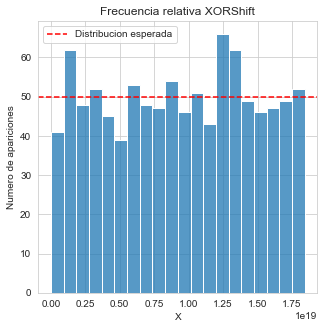

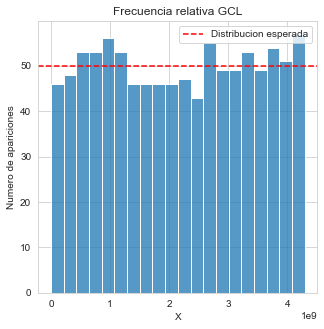

In [299]:
sns.histplot(data=generated,bins=20)
plt.title('Frecuencia relativa XORShift')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

sns.histplot(data=gcl_generated,bins=20)
plt.title('Frecuencia relativa GCL')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

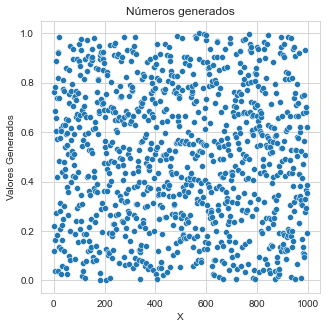

In [300]:
sns.scatterplot(data=gcl_uniform_generated)
plt.title('Números generados')
plt.xlabel("X")
plt.ylabel("Valores Generados")
plt.show()

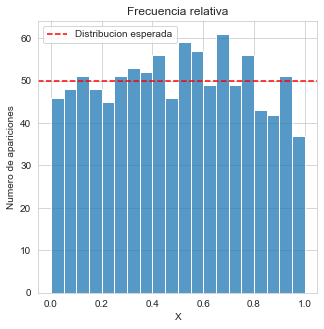

In [301]:
sns.histplot(data=gcl_uniform_generated,bins=20)
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.title('Frecuencia relativa')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.legend()
plt.show()

# Ejercicio 2

### Test de Kolmogorov

In [575]:
generator = XORShiftGenerator(int(time.time()))

def generate_sample(longitud):
    sample = []
    for i in range(longitud):
        sample.append(generator.uniform_random())
    return sample

def kol_test_sample(sample):
    tested = kstest(sample, 'uniform')
    if tested[1] >= 0.05:
        print("El test acepta la hipotesis nula.")
    else:
        print("El test rechaza la hipótesis nula")
    print("Estadistico: {:.4f} ".format(tested[0]))
    print("P Valor: {:.4f} ".format(tested[1]))

In [576]:
big_sample = generate_sample(10000)
kol_test_sample(big_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0079 
P Valor: 0.5510 


In [577]:
small_sample = generate_sample(1000)
kol_test_sample(small_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0250 
P Valor: 0.5535 


In [578]:
def gcl_generate_sample(longitud):
    sample = []
    for i in range(longitud):
        sample.append(gcl_generator.uniform_random())
    return sample

In [579]:
gcl_big_sample = gcl_generate_sample(10000)
kol_test_sample(gcl_big_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0112 
P Valor: 0.1629 


In [580]:
gcl_small_sample = gcl_generate_sample(1000)
kol_test_sample(gcl_small_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0204 
P Valor: 0.7897 


### Test Chi-Cuadrado

In [581]:
sample = generate_sample(10000)
sample

[0.5461992476637253,
 0.028267706769217207,
 0.48908498447594495,
 0.7639471285178902,
 0.5077842959180463,
 0.2882166407955123,
 0.04286368168214588,
 0.38081082729863797,
 0.42924799444178996,
 0.3471864473987527,
 0.1815710292574116,
 0.5712338923743367,
 0.3328820521281687,
 0.8695885684430914,
 0.7252116186053635,
 0.5231659683499735,
 0.9368203011040559,
 0.25943595831783484,
 0.29829135102902765,
 0.30840606811099713,
 0.10454552726552079,
 0.5801705172385359,
 0.6340441539248821,
 0.9803871254831172,
 0.3527906866720659,
 0.9555527776448943,
 0.8450738402288089,
 0.8962266037236154,
 0.5040791271159631,
 0.8116662963326933,
 0.45626712532147584,
 0.16579137139019706,
 0.7714347703718101,
 0.4204523031449991,
 0.6342983275765814,
 0.6563859744570051,
 0.870681345615708,
 0.541780264082734,
 0.5599520335876478,
 0.12729784302168815,
 0.9248448865449029,
 0.851788984180967,
 0.3480855626588636,
 0.5350100102240133,
 0.18958682170573835,
 0.95288433822316,
 0.5046970614231717,
 0.9

#### Discretisacion de la muestra

In [595]:
def in_range(value, start, end):
    return value > start and value <= end
        
def count_values(value):
    if in_range(value, 0, 0.1): return 1
    if in_range(value, 0.1, 0.2): return 2
    if in_range(value, 0.2, 0.3): return 3
    if in_range(value, 0.3, 0.4): return 4
    if in_range(value, 0.4, 0.5): return 5
    if in_range(value, 0.5, 0.6): return 6
    if in_range(value, 0.6, 0.7): return 7
    if in_range(value, 0.7, 0.8): return 8
    if in_range(value, 0.8, 0.9): return 9
    if in_range(value, 0.9, 1.0): return 10
    return 9

In [596]:
sample_count_values = list(map(lambda value: count_values(value), sample))

In [597]:
print(str(sample_count_values[0:5]) + '...')

[6, 1, 5, 8, 6]...


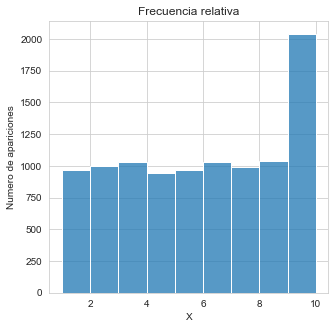

In [598]:
sns.histplot(data=sample_count_values, bins=9)
plt.title('Frecuencia relativa')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.show()

### Test 3

# Ejercicio 3

In [308]:
# genexp genera un valor de una variable Exp(lam) utilizando equivalencia de eventos contra una uniforme (0,1)
# ver: pag.4 de https://campusgrado.fi.uba.ar/pluginfile.php/29915/mod_page/content/419/Te%C3%B3rica%204%20Generaci%C3%B3n%20de%20variables%20continuas%20y%20discretas.pdf
def genexp(u, lam=1):
    return -np.log(1-u) / lam

def normalpdf(x, mu=0, sigma=1):
    var = np.square(sigma)
    return np.exp(-np.square(x - mu) / (2 * var)) / np.sqrt(2 * np.pi * var)
def exppdf(x, lam=1):
    return lam * np.exp(-lam * x)

# gennorm genera valores de una normal de media "mu" y desviación "sigma", utilizando un metodo de aceptación rechazo contra una variable Exp(1)
# ver: pag.9 de https://campusgrado.fi.uba.ar/pluginfile.php/29915/mod_page/content/419/Te%C3%B3rica%204%20Generaci%C3%B3n%20de%20variables%20continuas%20y%20discretas.pdf
def gennorm(N, mu=0, sigma=1):
    c = np.sqrt(2 * np.e / np.pi)
    t = np.array([genexp(generator.uniform_random()) for _ in range(N)])

    # probabilidad de aceptar
    p = normalpdf(t) / (c * exppdf(t))

    z = np.array([])
    for i in range(N):
        if generator.uniform_random() < p[i]:
            r2 = generator.uniform_random()
            val = t[i] if r2 < 0.5 else -t[i]
            z = np.concatenate((z, [sigma * val + mu]))

    return z

[Text(0.5, 0, 'Nros pseudoaleatorios'), Text(0, 0.5, 'Frecuencia')]

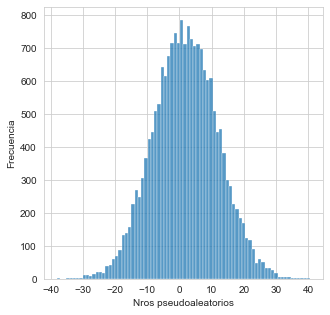

In [309]:
# Generamos una muestra de N=10000 y graficamos el histograma
N=50000

mu = 2.0
sigma = 10.0

data = gennorm(N, mu, sigma)
sns.histplot(data=data).set(xlabel="Nros pseudoaleatorios",ylabel="Frecuencia")

## Tests Estadísticos

In [310]:
def cdf(x):
    return norm.cdf(x, loc=mu, scale=sigma)

alfa = 0.05

### Test 1: Kolmogorov-Smirnov

In [311]:
K, pv = kstest(data, cdf)

print("K = %f, p-val = %f" % (K, pv))
print("Existe evidencia para rechazar que los datos no siguen una distribución normal (2,10)" if pv < alfa else "No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)")

K = 0.009106, p-val = 0.084511
No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)


### Test 2: Shapiro-Wilk

In [312]:
sorted_data = np.sort(data)

S, pv = shapiro(sorted_data)

print("S = %f, p-val = %f" % (S, pv))
print("Existe evidencia para rechazar que los datos no siguen una distribución normal (2,10)" if pv < alfa else "No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)")

S = 0.999892, p-val = 0.580163
No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)


/Users/sebastianripari/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Ejercicio 4

La llegada de vehiculos a un estacionamiento sigue un proceso de Poisson de tasa lamda vehiculos/hora.

In [313]:
tiempo_entre_arribos = pd.read_csv('tiempos_entre_arribos.txt', header=None)

In [314]:
tiempo_entre_arribos

,0
0,0.028390
1,0.294435
2,0.048560
3,0.140468
4,0.023268
...,...
9995,0.216236
9996,0.099258
9997,0.163479
9998,0.121538


#### Estimacion de la tasa de arribos

In [315]:
cantidad_arribos = len(tiempo_entre_arribos)
cantidad_arribos

10000

In [316]:
tiempo_total = tiempo_entre_arribos[0].sum()
tiempo_total

1011.1994386169151

In [317]:
lambda_ = cantidad_arribos / tiempo_total
lambda_

9.889245996494685

#### Simulacion de llegada de vehiculos con generador XorShift

In [318]:
# cantidad de arribos
n = 10

# arribos
arribos = []

arribo = 0

generator = XORShiftGenerator(int(time.time()))

# 1 mes en horas
mes = 24 * 30

while arribo < mes:
    # tiempo en horas
    z = genexp(generator.uniform_random(), lam=lambda_)
    arribo = arribo + z
    arribos.append(arribo)

In [319]:
print("Cantidad de arribos en un mes: " + str(len(arribos)))

Cantidad de arribos en un mes: 7259


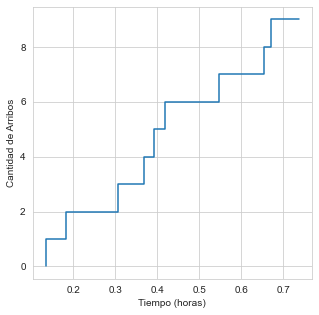

In [320]:
plt.step(arribos[0:10], range(len(arribos[0:10])))
plt.xlabel('Tiempo (horas)')
plt.ylabel('Cantidad de Arribos')
plt.show()

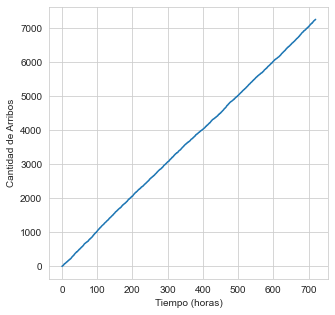

In [321]:
plt.step(arribos, range(len(arribos)))
plt.xlabel('Tiempo (horas)')
plt.ylabel('Cantidad de Arribos')
plt.show()

#### Generacion 1000 arribos con el proceso de Poisson

In [322]:
# cantidad de arribos
n = 1000

# arribos
arribos = []

arribo = 0

for i in range(n):
    z = np.random.exponential(1/lambda_)
    arribo = arribo + z
    arribos.append(arribo)

In [323]:
arribos[0:5]

[0.469711062427876,
 0.511975885544428,
 0.5242997295184028,
 0.8592179967361684,
 1.0033431197024938]

#### Probabilidad de que el primer vehiculo arribe antes de los 10 minutos 

Paso 10 minutos a horas. 10 -> 10 / 60 = 0.16

\begin{equation}
P(X_1 < 0.16) = 1 - P(X_1 > 0.16)
\end{equation}

Prababilidad de que el primer arribo sea despues de los 10 minutos, es lo mismo que pedir que durante los primeros 10 minutos no haya arribos

\begin{equation}
P(X_1 > 0.16) = P(N_{(0, 0.16]} = 0)
\end{equation}

\begin{equation}
P(N_{(s,t]}=x) = \frac{e^{-\lambda (t-s)} (\lambda (t-s))^x }{x!}
\end{equation}

\begin{equation}
P(N_{(0,0.16]}=0) = \frac{e^{-\lambda 0.16} (\lambda 0.16)^0 }{0!}
\end{equation}

Tomando que los tiempos entre arribos son en horas. Tenemos que t es (10 * 100) / 60 = 16.6666666667

In [324]:
def prob(t, x, lambda_):
    numerador = (math.e ** (-(lambda_ * t))) * ((lambda_ * t) ** x) 
    denominador =  math.factorial(x)
    return numerador / denominador

In [325]:
1 - prob(0.16, 0, lambda_)

0.7944938584160515

Por lo tanto la probabilidad pedida practicamente un 80%.

#### Probabilidad de que el undecimo vehiculo arribe despues de los 60 minutos

Paso a horas. 60 min -> 1 h

\begin{equation}
P(X_{11} > 1)
\end{equation}

Esto es lo mismo que pedir que hasta 1 hora, haya <= 10 arribos.

\begin{equation}
P(N_{(0,1]} <= 10) = \sum\limits_{i=0}^{10} P(N_{(0,1]} = i)
\end{equation}

In [326]:
sum_ = 0
for i in range(10):
    sum_ = sum_ + prob(1, i, lambda_)
sum_

0.4718605839507912

#### Probabilidad de que arriben al menos 750 vehiculos antes de las 72 horas

Esto es lo mismo que pedir que hasta 72 horas, haya > 750 arribos.

\begin{equation}
P(N_{(0,72]} > 750) = 1 - P(N_{(0,72]} <= 750) = 1 - \sum\limits_{i=0}^{750} P(N_{(0,72]} = i)
\end{equation}

In [327]:
sum_ = 0
results = [] 
for i in range(750):
    if i < 108: # ver anexo
        results.append(prob(72, i, lambda_))
        sum_ = sum_ + prob(72, i, lambda_)
1 - sum_

1.0

La probabilidad es 1

##### Anexo

Con arribos mayores a 108 no tenemos la posibilidad de calcularlo un un error de overflow. Pero podemos asumir que son practicamente 0, ya que son valores muy pequeños, notar que la sumatoria de los 108 calculos es un valor infimo.

In [328]:
prob(72, 109, lambda_)

/Users/sebastianripari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


inf

In [329]:
sum(results)

9.335133058845929e-177

# Ejercicio 5

In [389]:
f = open('caba_barrios.json')
data = json.load(f)

In [410]:
def get_polygon_barrio_by_name(name):
    barrios = data["features"]
    for barrio in barrios:
        if barrio["properties"]["BARRIO"] == name:
            coordinates = barrio["geometry"]['coordinates'][0][0]
            print("coordinates: {} ...".format(coordinates[0:5]))
            return Polygon(coordinates)
    return []

coordinates: [[-58.46557681285407, -34.59655770780579], [-58.46562010948453, -34.596704306733564], [-58.465540216548725, -34.59664630163081], [-58.46545058351525, -34.59661891152001], [-58.46533988591098, -34.59661194039792]] ...


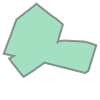

In [411]:
paternal = get_polygon_barrio_by_name("PATERNAL")
paternal

In [376]:
def random_points_in_bounds(polygon, number):
    points = []
    while len(points) < number:
        minx, miny, maxx, maxy = polygon.bounds    
        x = minx + ((maxx - minx) * generator.uniform_random())
        y = miny + ((maxy - miny) * generator.uniform_random())
        point = Point(x, y)
        if polygon.contains(point):
            points.append(point)
    return points

In [412]:
def plot_polygon_and_points(polygon, points):
    # plot the polygon
    xp,yp = polygon.exterior.xy
    plt.plot(xp,yp)
    
    # plot the list of points
    xs = [point.x for point in points]
    ys = [point.y for point in points]
    plt.scatter(xs, ys,color="red")
    plt.show()

In [413]:
points = random_points_in_bounds(poligon_object, 20)

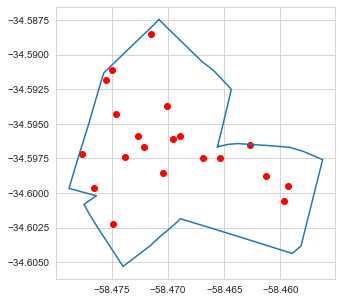

In [414]:
plot_polygon_and_points(paternal, points)

coordinates: [[-58.43060582833087, -34.60704708859627], [-58.43055990202167, -34.60775365188757], [-58.43054944602487, -34.607918867190364], [-58.430512846566, -34.608513737883264], [-58.43047392413131, -34.60872528515684]] ...


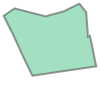

In [415]:
caballito = get_polygon_barrio_by_name("CABALLITO")
caballito

In [416]:
points = random_points_in_bounds(caballito, 20)

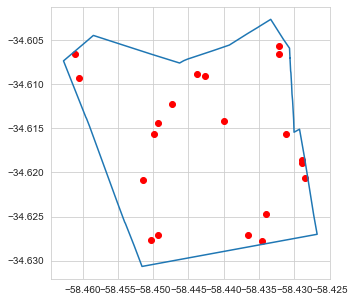

In [417]:
plot_polygon_and_points(caballito, points)